# [Predictive Clinical Neuroscience Toolkit](https://github.com/amarquand/PCNtoolkit) 
# Hierarchical Bayesian Regression Normative Modelling and Transfer onto unseen site.

This notebook will go through basic data preparation (training and testing set, [see Saige's tutorial](https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/blob/main/tutorials/BLR_protocol/BLR_normativemodel_protocol.ipynb) on Normative Modelling for more detail), the actual training of the models, and will finally describe how to transfer the trained models onto unseen sites. 

### Created by [Saige Rutherford](https://twitter.com/being_saige) 
### adapted/edited by Andre Marquand and Pierre Berthet

<div>
<img src="https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/blob/main/data/NormModelSetup.png?raw=1" width="500"/>
</div>

## Step 0: Install necessary libraries & grab data files

In [ ]:
! pip uninstall -y Theano-PyMC  # conflicts with Theano on some environments
! pip install pcntoolkit==0.22

For this tutorial we will use data from the [Functional Connectom Project FCON1000](http://fcon_1000.projects.nitrc.org/) to create a multi-site dataset. 

The dataset contains some cortical measures (eg thickness), processed by Freesurfer 6.0, and some covariates (eg age, site, gender).

First we import the required package, and create a working directory.

In [14]:
import os
import pandas as pd
import pcntoolkit as ptk
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [15]:
processing_dir = "HBR_demo/"    # replace with a path to your working directory
if not os.path.isdir(processing_dir):
    os.makedirs(processing_dir)
os.chdir(processing_dir)
processing_dir = os.getcwd()

#### Overview
Here we get the FCON dataset, remove the ICBM site for later transfer, assign some site id to the different scanner sites and print an overview of the left hemisphere mean raw cortical thickness as a function of age, color coded by the various sites:


/tmp/ipykernel_13126/2504982896.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icbm['sitenum'] = 0
/tmp/ipykernel_13126/2504982896.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcon['sitenum'].loc[idx] = i


site AnnArbor_a 24
site AnnArbor_b 32
site Atlanta 28
site Baltimore 23
site Bangor 20
site Beijing_Zang 198
site Berlin_Margulies 26
site Cambridge_Buckner 198
site Cleveland 31
site Leiden_2180 12
site Leiden_2200 19
site Milwaukee_b 46
site Munchen 15
site NewYork_a 83
site NewYork_a_ADHD 25
site Newark 19
site Oulu 102
site Oxford 22
site PaloAlto 17
site Queensland 19
site SaintLouis 31


Text(0.5, 0, 'age')

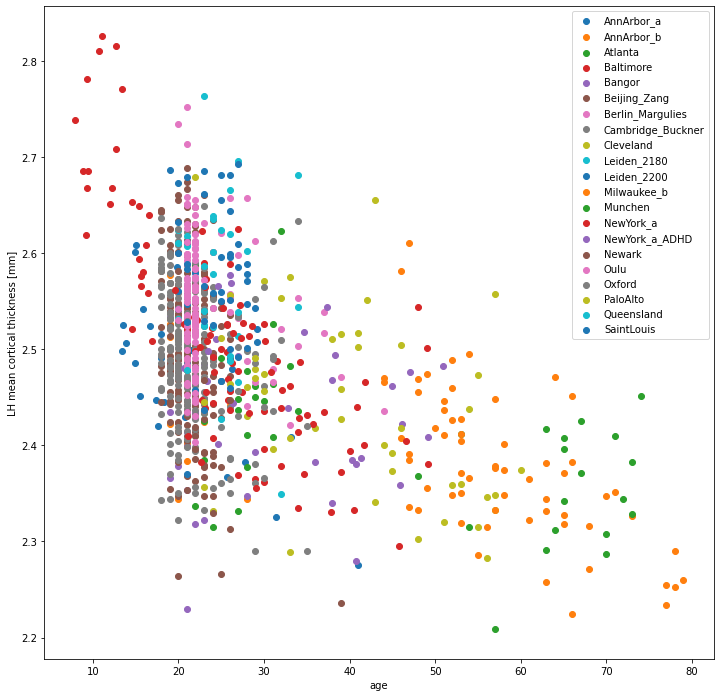

In [16]:
fcon = pd.read_csv('https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/main/data/fcon1000.csv')

# extract the ICBM site for transfer
icbm = fcon.loc[fcon['site'] == 'ICBM']
icbm['sitenum'] = 0

# remove from the training set (also Pittsburgh because it only has 3 samples)
fcon = fcon.loc[fcon['site'] != 'ICBM']
fcon = fcon.loc[fcon['site'] != 'Pittsburgh']

sites = fcon['site'].unique()
fcon['sitenum'] = 0

f, ax = plt.subplots(figsize=(12, 12))

for i,s in enumerate(sites):
    idx = fcon['site'] == s
    fcon['sitenum'].loc[idx] = i
    
    print('site',s, sum(idx))
    ax.scatter(fcon['age'].loc[idx], fcon['lh_MeanThickness_thickness'].loc[idx])
    
ax.legend(sites)
ax.set_ylabel('LH mean cortical thickness [mm]')
ax.set_xlabel('age')


## Step 1: Prepare training and testing sets

Then we randomly split half of the samples (participants) to be either in the training or in the testing samples. We do this for the remaing FCON dataset and for the ICBM data. The transfer function will also require a training and a test sample. 

The numbers of samples per sites used for training and for testing are then displayed.

In [17]:
tr = np.random.uniform(size=fcon.shape[0]) > 0.5
te = ~tr
    
fcon_tr = fcon.loc[tr]
fcon_te = fcon.loc[te]
    
tr = np.random.uniform(size=icbm.shape[0]) > 0.5
te = ~tr
    
icbm_tr = icbm.loc[tr]
icbm_te = icbm.loc[te]
    
print('sample size check')
for i,s in enumerate(sites):
    idx = fcon_tr['site'] == s
    idxte = fcon_te['site'] == s
    print(i,s, sum(idx), sum(idxte))
    
fcon_tr.to_csv(processing_dir + '/fcon1000_tr.csv')
fcon_te.to_csv(processing_dir + '/fcon1000_te.csv')
icbm_tr.to_csv(processing_dir + '/fcon1000_icbm_tr.csv')
icbm_te.to_csv(processing_dir + '/fcon1000_icbm_te.csv')

sample size check
0 AnnArbor_a 13 11
1 AnnArbor_b 13 19
2 Atlanta 14 14
3 Baltimore 11 12
4 Bangor 9 11
5 Beijing_Zang 99 99
6 Berlin_Margulies 16 10
7 Cambridge_Buckner 110 88
8 Cleveland 15 16
9 Leiden_2180 5 7
10 Leiden_2200 7 12
11 Milwaukee_b 24 22
12 Munchen 5 10
13 NewYork_a 36 47
14 NewYork_a_ADHD 13 12
15 Newark 5 14
16 Oulu 52 50
17 Oxford 9 13
18 PaloAlto 10 7
19 Queensland 9 10
20 SaintLouis 16 15


Otherwise you can just load these pre defined subsets:

In [19]:
# Optional
#fcon_tr = pd.read_csv('https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/main/data/fcon1000_tr.csv')
#fcon_te = pd.read_csv('https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/main/data/fcon1000_te.csv')
#icbm_tr = pd.read_csv('https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/main/data/fcon1000_icbm_tr.csv')
#icbm_te = pd.read_csv('https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/main/data/fcon1000_icbm_te.csv')

## Step 2: Configure HBR inputs: covariates, measures and batch effects

We will here only use the mean cortical thickness for the Right and Left hemisphere: two idps.


In [18]:
idps = ['rh_MeanThickness_thickness','lh_MeanThickness_thickness']

As input to the model, we need covariates (used to describe predictable source of variability (fixed effects), here 'age'), measures (here cortical thickness on two idps), and batch effects (random source of variability, here 'scanner site' and 'sex').

`X` corresponds to the covariate(s) 

`Y` to the measure(s)

`batch_effects` to the random effects

We need these values both for the training (`_train`) and for the testing set (`_test`).

In [22]:
X_train = (fcon_tr['age']/100).to_numpy(dtype=float)
Y_train = fcon_tr[idps].to_numpy(dtype=float)

# configure batch effects for site and sex
# batch_effects_train = fcon_tr[['sitenum','sex']].to_numpy(dtype=int)

# or only site
batch_effects_train = fcon_tr[['sitenum']].to_numpy(dtype=int)
    
with open('X_train.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_train), file)
with open('Y_train.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Y_train), file) 
with open('trbefile.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_train), file) 


X_test = (fcon_te['age']/100).to_numpy(dtype=float)
Y_test = fcon_te[idps].to_numpy(dtype=float)
#batch_effects_test = fcon_te[['sitenum','sex']].to_numpy(dtype=int)
batch_effects_test = fcon_te[['sitenum']].to_numpy(dtype=int)
    
with open('X_test.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_test), file)
with open('Y_test.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Y_test), file) 
with open('tsbefile.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_test), file) 

# a simple function to quickly load pickle files    
def ldpkl(filename: str): 
    with open(filename, 'rb') as f:
        return pickle.load(f)

## Step 3: Files and Folders grooming

In [23]:
respfile = os.path.join(processing_dir, 'Y_train.pkl')       # measurements  (eg cortical thickness) of the training samples (columns: the various features/ROIs, rows: observations or subjects)
covfile = os.path.join(processing_dir, 'X_train.pkl')        # covariates (eg age) the training samples (columns: covariates, rows: observations or subjects)

testrespfile_path = os.path.join(processing_dir, 'Y_test.pkl')       # measurements  for the testing samples
testcovfile_path = os.path.join(processing_dir, 'X_test.pkl')        # covariate file for the testing samples

trbefile = os.path.join(processing_dir, 'trbefile.pkl')      # training batch effects file (eg scanner_id, gender)  (columns: the various batch effects, rows: observations or subjects)
tsbefile = os.path.join(processing_dir, 'tsbefile.pkl')      # testing batch effects file

output_path = os.path.join(processing_dir, 'Models/')    #  output path, where the models will be written
log_dir = os.path.join(processing_dir, 'log/')           #
if not os.path.isdir(output_path):
    os.mkdir(output_path)
if not os.path.isdir(log_dir):
    os.mkdir(log_dir)

outputsuffix = '_estimate'      # a string to name the output files, of use only to you, so adapt it for your needs.

## Step 4: Estimating the models

Now we have everything ready to estimate the normative models. The `estimate` function only needs the training and testing sets, each divided in three datasets: covariates, measures and batch effects. We obviously specify `alg=hbr` to use the hierarchical bayesian regression method, well suited for the multi sites datasets. The remaining arguments are basic data management: where the models, logs, and output files will be written and how they will be named.

In [24]:
ptk.normative.estimate(covfile=covfile, 
                       respfile=respfile,
                       tsbefile=tsbefile, 
                       trbefile=trbefile, 
                       inscaler='standardize',
                       outscaler='standardize',
                       linear_mu='True',
                       random_intercept_mu='True',
                       centered_intercept_mu='True',
                       alg='hbr', 
                       log_path=log_dir, 
                       binary=True,
                       output_path=output_path, 
                       testcov= testcovfile_path,
                       testresp = testrespfile_path,
                       outputsuffix=outputsuffix, 
                       savemodel=True)

Processing data in /home/preclineu/andmar/sfw/PCNtoolkit-demo/tutorials/HBR_FCON/HBR_demo/HBR_demo/Y_train.pkl
Estimating model  1 of 2
slope_mu <class 'pcntoolkit.model.hbr.FixedParameterization'>
slope_mu
dist=normal
params=(0.0, 1.0)
intercept_mu <class 'pcntoolkit.model.hbr.CentralRandomFixedParameterization'>
mu_intercept_mu
dist=normal
params=(0.0, 1.0)
sigma_intercept_mu
dist=hcauchy
params=(1.0,)
mu <class 'pcntoolkit.model.hbr.LinearParameterization'>
sigma <class 'pcntoolkit.model.hbr.FixedParameterization'>
sigma
dist=normal
params=(0.0, 1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, intercept_mu, sigma_intercept_mu, mu_intercept_mu, slope_mu]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 52 seconds.
There were 230 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


slope_mu <class 'pcntoolkit.model.hbr.FixedParameterization'>
slope_mu
dist=normal
params=(0.0, 1.0)
intercept_mu <class 'pcntoolkit.model.hbr.CentralRandomFixedParameterization'>
mu_intercept_mu
dist=normal
params=(0.0, 1.0)
sigma_intercept_mu
dist=hcauchy
params=(1.0,)
mu <class 'pcntoolkit.model.hbr.LinearParameterization'>
sigma <class 'pcntoolkit.model.hbr.FixedParameterization'>
sigma
dist=normal
params=(0.0, 1.0)


Estimating model  2 of 2
slope_mu <class 'pcntoolkit.model.hbr.FixedParameterization'>
slope_mu
dist=normal
params=(0.0, 1.0)
intercept_mu <class 'pcntoolkit.model.hbr.CentralRandomFixedParameterization'>
mu_intercept_mu
dist=normal
params=(0.0, 1.0)
sigma_intercept_mu
dist=hcauchy
params=(1.0,)
mu <class 'pcntoolkit.model.hbr.LinearParameterization'>
sigma <class 'pcntoolkit.model.hbr.FixedParameterization'>
sigma
dist=normal
params=(0.0, 1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, intercept_mu, sigma_intercept_mu, mu_intercept_mu, slope_mu]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 49 seconds.
There were 266 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


slope_mu <class 'pcntoolkit.model.hbr.FixedParameterization'>
slope_mu
dist=normal
params=(0.0, 1.0)
intercept_mu <class 'pcntoolkit.model.hbr.CentralRandomFixedParameterization'>
mu_intercept_mu
dist=normal
params=(0.0, 1.0)
sigma_intercept_mu
dist=hcauchy
params=(1.0,)
mu <class 'pcntoolkit.model.hbr.LinearParameterization'>
sigma <class 'pcntoolkit.model.hbr.FixedParameterization'>
sigma
dist=normal
params=(0.0, 1.0)


Saving model meta-data...
Evaluating the model ...
Writing outputs ...


Here some analyses can be done, there are also some error metrics that could be of interest. This is covered in step 6 and in [Saige's tutorial](https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/blob/main/tutorials/BLR_protocol/BLR_normativemodel_protocol.ipynb) on Normative Modelling.

## Step 5: Transfering the models to unseen sites

Similarly to what was done before for the FCON data, we also need to prepare the ICBM specific data, in order to run the transfer function: training and testing set of covariates, measures and batch effects:

In [25]:
X_adapt = (icbm_tr['age']/100).to_numpy(dtype=float)
Y_adapt = icbm_tr[idps].to_numpy(dtype=float)
batch_effects_adapt = icbm_tr[['sitenum','sex']].to_numpy(dtype=int)
    
with open('X_adaptation.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_adapt), file)
with open('Y_adaptation.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Y_adapt), file) 
with open('adbefile.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_adapt), file) 

# Test data (new dataset)
X_test_txfr = (icbm_te['age']/100).to_numpy(dtype=float)
Y_test_txfr = icbm_te[idps].to_numpy(dtype=float)
batch_effects_test_txfr = icbm_te[['sitenum','sex']].to_numpy(dtype=int)
    
with open('X_test_txfr.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_test_txfr), file)
with open('Y_test_txfr.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Y_test_txfr), file) 
with open('txbefile.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_test_txfr), file) 


In [26]:
respfile = os.path.join(processing_dir, 'Y_adaptation.pkl')
covfile = os.path.join(processing_dir, 'X_adaptation.pkl')
testrespfile_path = os.path.join(processing_dir, 'Y_test_txfr.pkl')
testcovfile_path = os.path.join(processing_dir, 'X_test_txfr.pkl')
trbefile = os.path.join(processing_dir, 'adbefile.pkl')
tsbefile = os.path.join(processing_dir, 'txbefile.pkl')

log_dir = os.path.join(processing_dir, 'log_transfer/')
output_path = os.path.join(processing_dir, 'Transfer/')
model_path = os.path.join(processing_dir, 'Models/')  # path to the previously trained models
outputsuffix = '_transfer'  # suffix added to the output files from the transfer function

Here, the difference is that the transfer function needs a model path, which points to the models we just trained, and new site data (training and testing). That is basically the only difference.

In [27]:
yhat, s2, z_scores = ptk.normative.transfer(covfile=covfile, 
                                            respfile=respfile,
                                            tsbefile=tsbefile, 
                                            trbefile=trbefile, 
                                            model_path = model_path,
                                            alg='hbr', 
                                            log_path=log_dir, 
                                            binary=True,
                                            output_path=output_path, 
                                            testcov= testcovfile_path,
                                            testresp = testrespfile_path,
                                            outputsuffix=outputsuffix, 
                                            savemodel=True)

Loading data ...
Transferring model  1 of 2
slope_mu <class 'pcntoolkit.model.hbr.FixedParameterization'>
intercept_mu <class 'pcntoolkit.model.hbr.CentralRandomFixedParameterization'>
sigma_intercept_mu
dist=hcauchy
params=(1.0,)
mu <class 'pcntoolkit.model.hbr.LinearParameterization'>
sigma <class 'pcntoolkit.model.hbr.FixedParameterization'>


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, intercept_mu, sigma_intercept_mu, mu_intercept_mu, slope_mu]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 4 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


slope_mu <class 'pcntoolkit.model.hbr.FixedParameterization'>
intercept_mu <class 'pcntoolkit.model.hbr.CentralRandomFixedParameterization'>
sigma_intercept_mu
dist=hcauchy
params=(1.0,)
mu <class 'pcntoolkit.model.hbr.LinearParameterization'>
sigma <class 'pcntoolkit.model.hbr.FixedParameterization'>


ValueError: could not broadcast input array from shape (45,1) into shape (45,)

And that is it, you now have models that benefited from prior knowledge about different scanner sites to learn on unseen sites.

## Step 6: Interpreting model performance

Output evaluation metrics definitions: 
* yhat - predictive mean
* ys2 - predictive variance
* nm - normative model
* Z - deviance scores
* Rho - Pearson correlation between true and predicted responses
* pRho - parametric p-value for this correlation
* RMSE - root mean squared error between true/predicted responses
* SMSE - standardised mean squared error
* EV - explained variance
* MSLL - mean standardized log loss
    * See page 23 in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf